## Lab 2

Choosed Sheakspeare

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os
import numpy as np

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text)
text = text.lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [13]:
# !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
# with open('onegin.txt', 'r') as iofile:
#     text = iofile.readlines()
    
# text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

Put all the characters, that you've seen in the text, into variable `tokens`.

In [4]:
tokens = sorted(set(text))

In [5]:
tokens

['\n',
 ' ',
 '!',
 "'",
 '(',
 ')',
 ',',
 '-',
 '.',
 ':',
 ';',
 '?',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [6]:
token_to_idx = {}
idx_to_token = {}

# Populate char_to_index dictionary
for index, char in enumerate(tokens):
    token_to_idx[char] = index

# Populate index_to_char dictionary
for index, char in enumerate(tokens):
    idx_to_token[index] = char

In [8]:
def to_matrix(
    sentences, max_len=None, pad=token_to_idx[' '], dtype='int32', batch_first=True
    ):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, sentences))
    max_len += 1
    names_ix = np.zeros([len(sentences), max_len], dtype) + pad
#     names_ix[:, 0] = token_to_id['<'] # <SOS>

    for i in range(len(sentences)):
        line_ix = [token_to_idx[c] for c in sentences[i]]
        names_ix[i, :len(line_ix)] = line_ix
#         names_ix[i, len(line_ix)] = token_to_idx['>'] # <EOS>

        
    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

In [9]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In [10]:
text_lower = [sent.lower() for sent in text]

In [11]:
example = text[40:45]
example = [sent.lower() for sent in example]
example

['  or who is he so fond will be the tomb,\n',
 '  of his self-love to stop posterity?\n',
 "  thou art thy mother's glass and she in thee\n",
 '  calls back the lovely april of her prime;\n',
 '  so thou through windows of thine age shalt see,\n']

In [12]:
to_matrix(example)

array([[ 1,  1, 26, 29,  1, 34, 19, 26,  1, 20, 30,  1, 19, 16,  1, 30,
        26,  1, 17, 26, 25, 15,  1, 34, 20, 23, 23,  1, 13, 16,  1, 31,
        19, 16,  1, 31, 26, 24, 13,  6,  0,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1],
       [ 1,  1, 26, 17,  1, 19, 20, 30,  1, 30, 16, 23, 17,  7, 23, 26,
        33, 16,  1, 31, 26,  1, 30, 31, 26, 27,  1, 27, 26, 30, 31, 16,
        29, 20, 31, 36, 11,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1],
       [ 1,  1, 31, 19, 26, 32,  1, 12, 29, 31,  1, 31, 19, 36,  1, 24,
        26, 31, 19, 16, 29,  3, 30,  1, 18, 23, 12, 30, 30,  1, 12, 25,
        15,  1, 30, 19, 16,  1, 20, 25,  1, 31, 19, 16, 16,  0,  1,  1,
         1,  1,  1],
       [ 1,  1, 14, 12, 23, 23, 30,  1, 13, 12, 14, 22,  1, 31, 19, 16,
         1, 23, 26, 33, 16, 23, 36,  1, 12, 27, 29, 20, 23,  1, 26, 17,
         1, 19, 16, 29,  1, 27, 29, 20, 24, 16, 10,  0,  1,  1,  1,  1,
         1,  1,  1],
       [ 1,  1, 30, 26,  1, 31, 19, 26, 32,  1, 31, 

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [13]:
import torch
from torch import nn

In [16]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=18, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)
        h_next = self.rnn_update(x_and_h)
        
        h_next = torch.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)
        
        return h_next, logits
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [17]:
char_rnn = CharRNNCell()

In [19]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logits = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logits_next = char_rnn(x_t, hid_state)
        logits.append(logits_next)
        
    return torch.stack(logits, dim=1)

In [20]:
num_tokens = len(tokens)
num_tokens

38

In [21]:
batch_ix = to_matrix(example)
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logit_seq = rnn_loop(char_rnn, batch_ix)

# assert torch.max(logp_seq).data.numpy() <= 0
# assert tuple(logp_seq.size()) ==  batch_ix.shape + (num_tokens,)

In [23]:
logit_seq.shape

torch.Size([5, 51, 38])

In [24]:
predictions_logits = logit_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]

In [25]:
loss_func = nn.CrossEntropyLoss()
loss2 = loss_func(
    predictions_logits.reshape((-1, num_tokens)),
    actual_next_tokens.reshape(-1)
    )

In [26]:
loss2

tensor(3.6290, grad_fn=<NllLossBackward0>)

In [32]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
loss_func = nn.CrossEntropyLoss()

history = []

In [28]:
lengths = map(len, text_lower)

In [29]:
max(lengths)

63

In [30]:
import matplotlib.pyplot as plt

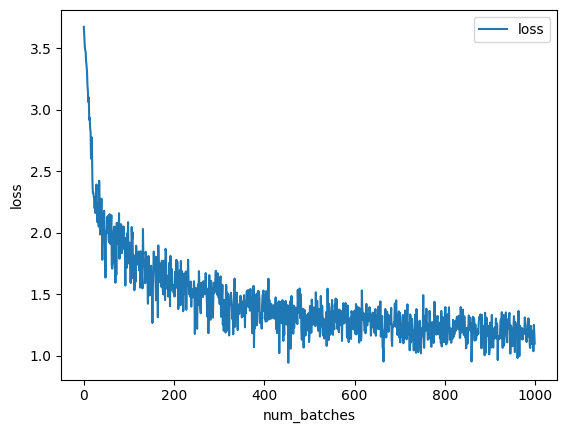

In [33]:
MAX_LENGTH = 63

for i in range(1000):
    batch_ix = to_matrix(sample(text_lower, 32), max_len=MAX_LENGTH)
#     print(batch_ix.shape)
#     print(sample)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logits_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    #<YOUR CODE>
    predictions_logits = logits_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = loss_func(
    predictions_logits.reshape((-1, num_tokens)),
    actual_next_tokens.reshape(-1)
    )
    loss.backward()
    opt.step()
    
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.xlabel('num_batches')
        plt.ylabel('loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [34]:
import torch.nn.functional as F

In [61]:
def generate_sample_rnn(char_rnn, seed_phrase=' hello', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
    '''
    
    x_sequence = to_matrix([seed_phrase], max_len=63)
    x_sequence = torch.tensor(x_sequence, dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, out = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, out = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [63]:
generate_sample_rnn(char_rnn, seed_phrase=' i love reinforcement learning', temperature = 1, max_length=2000)

" i love reinforcement learning                                  has mokkt then apl\n i  whs wand,\nl   sur such tring'd rhinging lave shere'r thamangein, onovinting yade is sounk youthre end aindou breall'd my selepd arow to all\n                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [64]:
generate_sample_rnn(char_rnn, seed_phrase=' i love reinforcement learning', temperature = 1, max_length=500)

' i love reinforcement learning                                  thmmess,\n                                                                                                                                                                                                                                                                                                                                                                                                                                                                             '

In [65]:
generate_sample_rnn(char_rnn, seed_phrase=' i love reinforcement learning', temperature = 0.8, max_length=500)

" i love reinforcement learning                                  thes  orld; thel's and a so shoust ther halp grome som unool the   and me i ter my sfone,\n                                                                                                                                                                                                                                                                                                                                                                                            "

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [37]:
from torch.nn import LSTM

In [39]:
class CharLSTMCell(nn.Module):
    def __init__(self, num_tokens=38, embedding_size=18, hidden_size=64):
        super(self.__class__, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.lstm = LSTM(embedding_size, self.hidden_size, batch_first=True)
        self.lstm_to_logits = nn.Linear(self.hidden_size, num_tokens)
        
    def forward(self, x, h_c_prev):
        x_emb = self.embedding(x)
        output, (hn, cn) = self.lstm(x_emb, h_c_prev)
        logits = self.lstm_to_logits(output)
        return logits, (hn, cn)
    
    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size, requires_grad=True).unsqueeze(0), torch.zeros(batch_size, self.hidden_size, requires_grad=True).unsqueeze(0)

In [40]:
def lstm_loop(lstm_cell, batch_ix):
    batch_size, max_length = batch_ix.size()
    hn, cn = lstm_cell.initial_state(batch_size)    

    logits, (hn, cn) = lstm_cell(batch_ix, (hn, cn))

        
    return logits

In [42]:
lstm_cell = CharLSTMCell()
history = []
opt = torch.optim.Adam(lstm_cell.parameters())

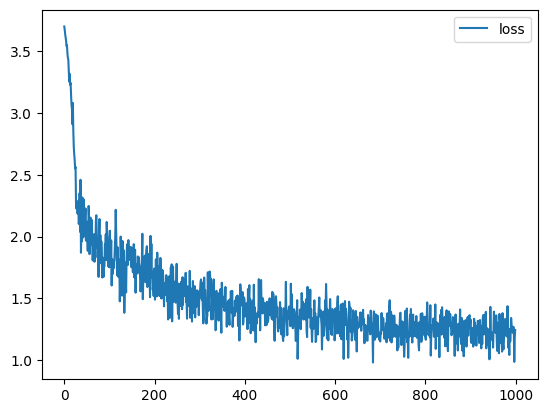

In [43]:
MAX_LENGTH = 63

for i in range(1000):
    batch_ix = to_matrix(sample(text_lower, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logits_seq = lstm_loop(lstm_cell, batch_ix)
    
    # compute loss
    predictions_logits = logits_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = loss_func(
    predictions_logits.reshape((-1, num_tokens)),
    actual_next_tokens.reshape(-1)
    )
    loss.backward()
    opt.step()
    
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "LSTM didn't converge."

In [271]:
lstm_cell.initial_state(batch_size=1)[1].shape

torch.Size([1, 1, 64])

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [44]:
def generate_sample(lstm_cell, seed_phrase=' hello', max_length=MAX_LENGTH, temperature=1.0):
    '''    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
    '''
    
    x_sequence = to_matrix([seed_phrase], max_len=63)
    x_sequence = torch.tensor(x_sequence, dtype=torch.int64)
    hid_state = lstm_cell.initial_state(batch_size=1)
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        logits, hid_state = lstm_cell(x_sequence[:, i].unsqueeze(0), hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        logits, hid_state = lstm_cell(x_sequence[:, -1].unsqueeze(0), hid_state)
        p_next = F.softmax(logits / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next.reshape(-1))
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [49]:
generate_sample(lstm_cell, seed_phrase=' what can i do', temperature = 0.1, max_length=200)

' what can i do                                                  the the and the the the the the the are sond the the serere,\n                                                                                                                             '

In [50]:
generate_sample(lstm_cell, seed_phrase=' what can i do', temperature = 0.2, max_length=200)

' what can i do                                                  the the the seast,\n                                                                                                                                                                       '

In [53]:
generate_sample(lstm_cell, seed_phrase=' what can i do', temperature = 0.5, max_length=200)

' what can i do                                                  and to the loth me may,\n                                                                                                                                                                  '

In [54]:
generate_sample(lstm_cell, seed_phrase=' what can i do', temperature = 1.0, max_length=200)

' what can i do                                                  untjo guvest my rent fargen?\n                                                                                                                                                             '

In [55]:
generate_sample(lstm_cell, seed_phrase=' what can i do', temperature = 2.0, max_length=200)

" what can i do                                                  p!may'g-igredct.\n  it ut !denitucdsrwtentoke.'-\n      u     oq-d, purmg yeny,':)e,;  athohtrlsssine roan,:eraf cnasild t?uikincfared-; wwikcembyus osq; moy fwonvor:\n        ?umts\n c - ko"

Чем больше температура, тем больше разнообразия в генерируемых токенах.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [56]:
torch.save(lstm_cell, 'lstm_sheakspeare.pt')

In [57]:
loaded_model = torch.load('lstm_sheakspeare.pt')

In [58]:
generate_sample(loaded_model, seed_phrase=' what can i do', temperature = 0.7, max_length=200)

' what can i do                                                  mee ben hos ando fare.\n                                                                                                                                                                   '

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)